In [1]:
# You will need an older version of plotly for this notebook
# !conda remove plotly -y && conda install -c plotly plotly=3.10.0=py_0 -y

In [2]:
# You will need orca to save to file. On ubuntu 18.04 there is a 
# documented missing dependency of libgconf2-4, which you should install
# in your environment with `sudo apt -y install libgconf2-4`
# !conda remove plotly-orca -y && conda install -c plotly plotly-orca==1.2.1 psutil requests -y

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sys
sys.path.append('../')
from common.plot_style_utils import set_pub_plot_context, save_for_pub

import plotly.plotly as py
import plotly.graph_objs as go
# This requires plotly-orca=1.2
import plotly.io as pio
from plotly.offline import init_notebook_mode, plot, iplot
import random

from scipy.stats import pearsonr
np.random.seed(42)
random.seed(42)
%matplotlib inline
init_notebook_mode(connected=True)

In [4]:
# Process the country predictions to get per-country data
predictions = np.load("../../data/results/rf/predictions_TEST_countries_seq_meta_nous.npy")
train_y = np.load("../../data/tts/y_train_country.pkl")
true = np.load("../../data/tts/y_test_country.pkl")
mask = ~(true == 33)
true = true[mask]
predictions = predictions[mask]
train_y = train_y[~(train_y == 33)]
class_labels = np.load("../../data/results/rf/classes_for_predictions_countries_seq_nous.npy")
# To translate y indexes to country names
encoder = pickle.load(open("../../data/encoders/country_to_index_ordinal_encoder.pkl","rb"))

In [5]:
predictions.shape

(3517, 33)

In [6]:
true.shape

(3517,)

In [7]:
def get_rf_labels(true,class_labels):
    tmp = [np.flatnonzero(class_labels == v) for v in true]
    return np.array([-1 if len(v) == 0 else v[0] for v in tmp])

def acc(pred, true, class_labels=class_labels):
    index = np.argmax(pred, axis=1)
    classes = class_labels[index]
    correct = (classes == true)
    #print(true.shape)
    accuracy = np.sum(correct) / len(true)
    return accuracy

def topkacc(pred,true,k,class_labels=class_labels):
    topkindices = np.argsort(pred)[:,-k:]
    #print(true.shape)
    true = get_rf_labels(true, class_labels)
    #print(f"True is {true.shape}, preds is {topkindices.shape}")
    correct = ((topkindices == true[:,None]).any(axis=1))
    #print(len(true))
    accuracy = np.sum(correct) / len(true)
    return accuracy

def best_guess(true, train_y=train_y, class_labels=class_labels):
    """ 
    Guesses most abundant class in the training set.
    """
    guess = np.argmax(np.bincount(np.asarray(train_y, dtype=int)))
    correct = (true == guess)
    accuracy = np.sum(correct) / len(true)
    return accuracy

In [8]:
mask = (true == 33)
predictions[mask].shape

(0, 33)

In [9]:
np.bincount(np.asarray(true, int))

array([235, 111,  24, 579,   0,  98,   4,  57,  48, 112, 520,   4,   9,
        18,   4,   5,  45,  28, 304, 130,   1,  14,  21,   8,  87,   9,
        45,   8, 100,  65, 246,   3, 575])

In [10]:
# These will be graphed elsewhere
print(f"Top 1 accuracy: {acc(predictions,true)}")
print(f"Top 3 accuracy: {topkacc(predictions,true,3)}")
print(f"Top 10 accuracy: {topkacc(predictions,true,10)}")
print(f"Top 1: Guess highest frequency: {np.max(np.bincount(np.asarray(train_y, dtype=np.int32)) / float(len(train_y)))}")
print(f"Top 1: Guess uniform: {1 / len(np.bincount(np.asarray(true, int)))}")
print(f"Top 3 guess highest frequency: {np.sum(np.sort(np.bincount(np.asarray(train_y, dtype=np.int32)))[-3:]) / float(len(train_y))}")
print(f"Top 10: Guess highest frequency: {np.sum(np.sort(np.bincount(np.asarray(train_y, dtype=np.int32)))[-10:]) / float(len(train_y))}")
print(f"Top 10: Guess uniform: {1 / len(np.bincount(np.asarray(true, int)))*10}")

Top 1 accuracy: 0.7586010804663065
Top 3 accuracy: 0.8771680409439864
Top 10 accuracy: 0.9673016775661075
Top 1: Guess highest frequency: 0.1615513554129819
Top 1: Guess uniform: 0.030303030303030304
Top 3 guess highest frequency: 0.4704930350846772
Top 10: Guess highest frequency: 0.8385642448413386
Top 10: Guess uniform: 0.30303030303030304


In [11]:
encoder.inverse_transform(np.arange(34).reshape(-1,1))

array([['Australia'],
       ['Austria'],
       ['Belgium'],
       ['Canada'],
       ['Chile'],
       ['China'],
       ['Czech Republic'],
       ['Denmark'],
       ['Finland'],
       ['France'],
       ['Germany'],
       ['Greece'],
       ['Hong Kong'],
       ['Hungary'],
       ['India'],
       ['Ireland'],
       ['Israel'],
       ['Italy'],
       ['Japan'],
       ['Netherlands'],
       ['New Zealand'],
       ['Norway'],
       ['Poland'],
       ['Portugal'],
       ['Republic of Korea'],
       ['Russian Federation'],
       ['Singapore'],
       ['South Africa'],
       ['Spain'],
       ['Sweden'],
       ['Switzerland'],
       ['Taiwan'],
       ['United Kingdom'],
       ['United States']], dtype=object)

In [12]:
# I need to drop wherever there is not at least 4 data points
todrop = np.bincount(np.asarray(true, int)) < 5
sum(todrop)

6

In [13]:
class_subsets = []
for idx in class_labels:
    mask = (true == idx)
    class_subsets.append((idx,predictions[mask]))

In [14]:
accuracies = []
for idx, subset in class_subsets:
    accuracies.append((idx,acc(subset,np.array([idx]*len(subset)))))
accuracies

/home/sandias42/miniconda3/envs/attrib/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

invalid value encountered in long_scalars



[(0.0, 0.8127659574468085),
 (1.0, 0.6666666666666666),
 (2.0, 0.6666666666666666),
 (3.0, 0.8860103626943006),
 (4.0, nan),
 (5.0, 0.6122448979591837),
 (6.0, 0.0),
 (7.0, 0.7543859649122807),
 (8.0, 0.75),
 (9.0, 0.4642857142857143),
 (10.0, 0.8538461538461538),
 (11.0, 0.75),
 (12.0, 0.1111111111111111),
 (13.0, 0.5555555555555556),
 (14.0, 0.0),
 (15.0, 0.6),
 (16.0, 0.8),
 (17.0, 0.6428571428571429),
 (18.0, 0.7302631578947368),
 (19.0, 0.7538461538461538),
 (20.0, 0.0),
 (21.0, 0.6428571428571429),
 (22.0, 1.0),
 (23.0, 0.5),
 (24.0, 0.6206896551724138),
 (25.0, 0.3333333333333333),
 (26.0, 0.5333333333333333),
 (27.0, 0.625),
 (28.0, 0.58),
 (29.0, 0.6615384615384615),
 (30.0, 0.7195121951219512),
 (31.0, 1.0),
 (32.0, 0.7773913043478261)]

In [15]:
accuracies = np.array(accuracies)
print(accuracies.shape)
# Drop those with fewer than 3 examples
accuracies = np.asarray(accuracies[~todrop], object)
accuracies[:,0] = encoder.inverse_transform(accuracies[:,0].reshape(-1,1)).reshape(-1)
accuracies = pd.DataFrame(accuracies)
accuracies

(33, 2)


,0,1
0,Australia,0.812766
1,Austria,0.666667
2,Belgium,0.666667
3,Canada,0.88601
4,China,0.612245
5,Denmark,0.754386
6,Finland,0.75
7,France,0.464286
8,Germany,0.853846
9,Hong Kong,0.111111


In [16]:
# Russian federation and south korea are named differnetly
accuracies.iloc[20,0] = "Russia"
accuracies.iloc[19,0] = "Korea, South"

In [17]:
# Use this as a template instead of looking up the country codes
# for each
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')

df

,COUNTRY,GDP (BILLIONS),CODE
0,Afghanistan,21.71,AFG
1,Albania,13.40,ALB
2,Algeria,227.80,DZA
3,American Samoa,0.75,ASM
4,Andorra,4.80,AND
5,Angola,131.40,AGO
6,Anguilla,0.18,AIA
7,Antigua and Barbuda,1.24,ATG
8,Argentina,536.20,ARG
9,Armenia,10.88,ARM


In [18]:
df = df.iloc[:,[0,2]]
df

,COUNTRY,CODE
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,American Samoa,ASM
4,Andorra,AND
5,Angola,AGO
6,Anguilla,AIA
7,Antigua and Barbuda,ATG
8,Argentina,ARG
9,Armenia,ARM


In [19]:
df = df.set_index("COUNTRY")
print(df)

                       CODE
COUNTRY                    
Afghanistan             AFG
Albania                 ALB
Algeria                 DZA
American Samoa          ASM
Andorra                 AND
Angola                  AGO
Anguilla                AIA
Antigua and Barbuda     ATG
Argentina               ARG
Armenia                 ARM
Aruba                   ABW
Australia               AUS
Austria                 AUT
Azerbaijan              AZE
Bahamas, The            BHM
Bahrain                 BHR
Bangladesh              BGD
Barbados                BRB
Belarus                 BLR
Belgium                 BEL
Belize                  BLZ
Benin                   BEN
Bermuda                 BMU
Bhutan                  BTN
Bolivia                 BOL
Bosnia and Herzegovina  BIH
Botswana                BWA
Brazil                  BRA
British Virgin Islands  VGB
Brunei                  BRN
...                     ...
Sweden                  SWE
Switzerland             CHE
Syria               

In [20]:
df.index.values.tolist()

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo, Democratic Republic of the',
 'Congo, Republic of the',
 'Cook Islands',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Falkland Islands (Islas Malvinas)'

In [21]:
df = df.loc[accuracies.iloc[:,0],:]
df

,CODE
COUNTRY,
Australia,AUS
Austria,AUT
Belgium,BEL
Canada,CAN
China,CHN
Denmark,DNK
Finland,FIN
France,FRA
Germany,DEU


In [22]:
len(df)

27

In [23]:
set_pub_plot_context()
sns.color_palette()

[(0.5333333333333333, 0.8, 0.9333333333333333),
 (0.8, 0.4, 0.4666666666666667),
 (0.8666666666666667, 0.8, 0.4666666666666667),
 (0.06666666666666667, 0.4666666666666667, 0.2),
 (0.2, 0.13333333333333333, 0.5333333333333333),
 (0.6666666666666666, 0.26666666666666666, 0.6),
 (0.26666666666666666, 0.6666666666666666, 0.6),
 (0.6, 0.6, 0.2),
 (0.5333333333333333, 0.13333333333333333, 0.3333333333333333),
 (0.4, 0.06666666666666667, 0.0)]

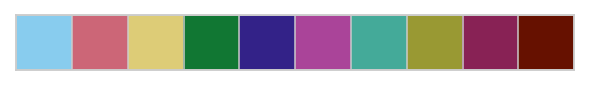

In [24]:
sns.palplot(sns.color_palette())

In [25]:
data = [go.Choropleth(
    locations = df['CODE'],
    z = accuracies.iloc[:,1]*100,
    text = df.index.values,
    colorscale = [
        #[0, "rgb(0.8, 0.4, 0.4666666666666667)"],
        #[0, "rgb(0.2, 0.13333333333333333, 0.5333333333333333)"],
        #[0, "rgb(0.5333333333333333, 0.8, 0.9333333333333333)"],
        #[0, "rgb(0.06666666666666667, 0.4666666666666667, 0.2)"],
        #[0, "rgb(0.5333333333333333, 0.13333333333333333, 0.3333333333333333)"],
        #[0, "rgb(0.4, 0.06666666666666667, 0.0)"],
        [0, "rgb(0.26666666666666666, 0.6666666666666666, 0.6)"],
        #[1, "rgb(220,220,220)"]
        #[1, "rgb(0.5333333333333333, 0.8, 0.9333333333333333)"]
        [1, "rgb(255,255,255)"]
    ],
    autocolorscale = False,
    reversescale = True,
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = 'rgb(180,180,180)',
            width = 1
            #color = 'rgb(255,255,255)',
            #width = 2
        )),
    colorbar = go.choropleth.ColorBar(
        tickprefix = '%',
        title = 'Accuracy (%)'),
)]

layout = go.Layout(
    title = go.layout.Title(
        text = 'Per-country Accuracy'
    ),
    geo = go.layout.Geo(
        scope="world",
        showframe = True,
        showcoastlines = True,
        projection = go.layout.geo.Projection(
            type = "robinson"
        )
    ),
)

fig = go.Figure(data = data, layout = layout)
iplot(fig, filename = 'd3-world-map')
pio.write_image(fig, '../../data/manuscript/figs/3/full_nous.pdf')

In [26]:
# Now compute the effect of training set size on test set performance
# (with test-set error bars)

def acc_with_std(pred, true, class_labels=class_labels, samples=30, frac=.5):
    assert len(pred) == len(true)
    if len(pred) == 0:
        return (0,0)
    index = np.argmax(pred, axis=1)
    classes = class_labels[index]
    
    # sample
    acc_samples = []
    for i in range(samples):
        dice = np.random.random(size=len(index))
        # Fraction masked
        mask = dice < frac
        while np.sum(mask) == 0: # Stop divide by zeros
            dice = np.random.random(size=len(index))
            # Fraction masked
            mask = dice < frac
        
        classes_sample = classes[mask]
        true_sample = true[mask]
        correct = (classes_sample == true_sample)
        acc_samples.append(np.sum(correct) / len(true_sample))
    
    #print(acc_samples)
    
    accuracy = np.mean(acc_samples)
    std = np.std(acc_samples)
    return accuracy, std

In [27]:
i, subset = class_subsets[0]

acc_with_std(subset,np.array([i]*len(subset)),class_labels=class_labels)

(0.8096338944506909, 0.02835321004221222)

In [28]:
accuracies = []
for idx, subset in class_subsets:
    a, s = acc_with_std(subset,np.array([idx]*len(subset)))
    accuracies.append((idx,len(subset),a,s))
accuracies

[(0.0, 235, 0.8110743775016481, 0.0239791710370422),
 (1.0, 111, 0.6661281522154768, 0.03601190605459503),
 (2.0, 24, 0.651189137659726, 0.12379460474048208),
 (3.0, 579, 0.8822088773378843, 0.01329491096773475),
 (4.0, 0, 0, 0),
 (5.0, 98, 0.6036860531299006, 0.0597659098011343),
 (6.0, 4, 0.0, 0.0),
 (7.0, 57, 0.7636351806887854, 0.055998717984018585),
 (8.0, 48, 0.738356032190522, 0.07827962616049894),
 (9.0, 112, 0.45588318553860874, 0.049324043170134266),
 (10.0, 520, 0.8565569727483672, 0.018600424028431758),
 (11.0, 4, 0.75, 0.2813657169355689),
 (12.0, 9, 0.1228968253968254, 0.1035913515472904),
 (13.0, 18, 0.5715351315351316, 0.17338781177605306),
 (14.0, 4, 0.0, 0.0),
 (15.0, 5, 0.5399999999999999, 0.2661314072519926),
 (16.0, 45, 0.8003519843859279, 0.06032344289259463),
 (17.0, 28, 0.6405681165239989, 0.08865667746403495),
 (18.0, 304, 0.7238391843701518, 0.02085481898269246),
 (19.0, 130, 0.7594827193297756, 0.03259902784853324),
 (20.0, 1, 0.0, 0.0),
 (21.0, 14, 0.6344973

In [29]:
accuracies = np.array(accuracies)
encoder.inverse_transform(accuracies[:,0].reshape(-1,1)).reshape(-1)

array(['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'China',
       'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany',
       'Greece', 'Hong Kong', 'Hungary', 'India', 'Ireland', 'Israel',
       'Italy', 'Japan', 'Netherlands', 'New Zealand', 'Norway', 'Poland',
       'Portugal', 'Republic of Korea', 'Russian Federation', 'Singapore',
       'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Taiwan',
       'United Kingdom'], dtype=object)

In [30]:
accuracies = pd.DataFrame(accuracies, columns=["id","test_count","mean","std"])

In [31]:
accuracies

,id,test_count,mean,std
0,0.0,235.0,0.811074,0.023979
1,1.0,111.0,0.666128,0.036012
2,2.0,24.0,0.651189,0.123795
3,3.0,579.0,0.882209,0.013295
4,4.0,0.0,0.000000,0.000000
5,5.0,98.0,0.603686,0.059766
6,6.0,4.0,0.000000,0.000000
7,7.0,57.0,0.763635,0.055999
8,8.0,48.0,0.738356,0.078280
9,9.0,112.0,0.455883,0.049324


In [32]:
accuracies['country'] = encoder.inverse_transform(accuracies.iloc[:,0].values.reshape(-1,1)).reshape(-1)
accuracies

,id,test_count,mean,std,country
0,0.0,235.0,0.811074,0.023979,Australia
1,1.0,111.0,0.666128,0.036012,Austria
2,2.0,24.0,0.651189,0.123795,Belgium
3,3.0,579.0,0.882209,0.013295,Canada
4,4.0,0.0,0.000000,0.000000,Chile
5,5.0,98.0,0.603686,0.059766,China
6,6.0,4.0,0.000000,0.000000,Czech Republic
7,7.0,57.0,0.763635,0.055999,Denmark
8,8.0,48.0,0.738356,0.078280,Finland
9,9.0,112.0,0.455883,0.049324,France


In [33]:
train_y = np.load("../../data/tts/y_train_country.pkl")
display(train_y)
# Drop U.S
train_y = train_y[train_y != 33]
accuracies['train_count'] = np.bincount(np.asarray(train_y, int))
accuracies

array([33., 33., 33., ...,  3.,  3.,  3.])

,id,test_count,mean,std,country,train_count
0,0.0,235.0,0.811074,0.023979,Australia,1465
1,1.0,111.0,0.666128,0.036012,Austria,662
2,2.0,24.0,0.651189,0.123795,Belgium,68
3,3.0,579.0,0.882209,0.013295,Canada,2730
4,4.0,0.0,0.000000,0.000000,Chile,9
5,5.0,98.0,0.603686,0.059766,China,576
6,6.0,4.0,0.000000,0.000000,Czech Republic,28
7,7.0,57.0,0.763635,0.055999,Denmark,258
8,8.0,48.0,0.738356,0.078280,Finland,289
9,9.0,112.0,0.455883,0.049324,France,522


In [34]:
# Drop countries with fewer than 5 test examples
accuracies = accuracies[accuracies.test_count >= 5]
accuracies

,id,test_count,mean,std,country,train_count
0,0.0,235.0,0.811074,0.023979,Australia,1465
1,1.0,111.0,0.666128,0.036012,Austria,662
2,2.0,24.0,0.651189,0.123795,Belgium,68
3,3.0,579.0,0.882209,0.013295,Canada,2730
5,5.0,98.0,0.603686,0.059766,China,576
7,7.0,57.0,0.763635,0.055999,Denmark,258
8,8.0,48.0,0.738356,0.078280,Finland,289
9,9.0,112.0,0.455883,0.049324,France,522
10,10.0,520.0,0.856557,0.018600,Germany,2615
12,12.0,9.0,0.122897,0.103591,Hong Kong,37


In [35]:
accuracies.shape

(27, 6)

In [36]:

print(pearsonr(np.log2(accuracies['train_count']), accuracies['mean']))

(0.5896525836041671, 0.001208678133768901)


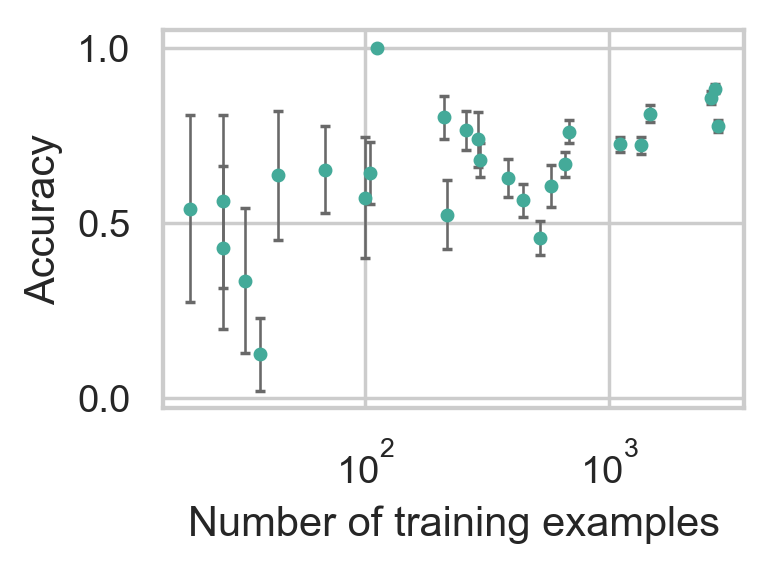

In [37]:
set_pub_plot_context(context="notebook")
fig = plt.figure(figsize=(3,2), dpi=250)
ax = fig.add_subplot(111,
                    xlabel="Number of training examples",
                    ylabel="Accuracy")
palette = sns.color_palette()
ax.errorbar(accuracies['train_count'], accuracies['mean'], accuracies['std'], 
            c=palette[6], linestyle="None", ecolor="dimgrey",marker="o", alpha=1,
            markersize=3, elinewidth=.75, capsize=1.5)
ax.set_xscale("log", base=2)
!mkdir ../../data/manuscript/figs/3/e
save_for_pub(fig, path="../../data/manuscript/figs/3/e/v0", dpi=500)